<a href="https://colab.research.google.com/github/mohamedaliELfeky/Money-count-Image-processing/blob/main/Money_Count.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# get Data

In [246]:
! git clone "https://github.com/mohamedaliELfeky/Money-count-Image-processing.git"

fatal: destination path 'Money-count-Image-processing' already exists and is not an empty directory.


# imports

In [247]:
from PIL import Image, ImageOps
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import glob
import re
from sklearn.cluster import kmeans_plusplus

# make dataset

In [248]:
train_path = "/content/Money-count-Image-processing/Train/"
test_path = "/content/Money-count-Image-processing/test/"

In [249]:
Train_path = glob.glob(train_path + '*.jpg')
test_path = glob.glob(test_path + '*.jpg')

In [250]:
Train_data = pd.DataFrame({"path":Train_path, "image":None,"face":None, "value":None})
test_data =  pd.DataFrame({"path":test_path, "image":None})

In [251]:
for i in range(len(Train_data)):
    image_path = Train_data.iloc[i]['path']
    image_v = Image.open(image_path)
    Train_data.iloc[i]["image"] = np.array(image_v)
    Train_data.iloc[i]["value"], Train_data.iloc[i]["face"] = re.findall(r'/(\d*.\d+|\d+)-(Front|front|Back|back)', image_path)[0]
    
    

In [252]:
for i in range(len(test_data)):
    image_path = test_data.iloc[i]['path']
    image_v = Image.open(image_path)
    test_data.iloc[i]["image"] = np.array(image_v)
    

In [253]:
Train_data['face'] = Train_data['face'].apply(lambda x:x.lower())
Train_data['value'] = Train_data['value'].astype('float16')

In [254]:
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   path    16 non-null     object 
 1   image   16 non-null     object 
 2   face    16 non-null     object 
 3   value   16 non-null     float16
dtypes: float16(1), object(3)
memory usage: 544.0+ bytes


# show sample

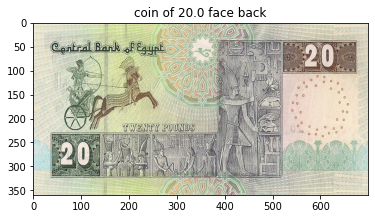

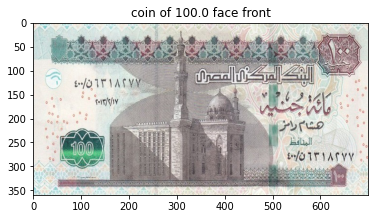

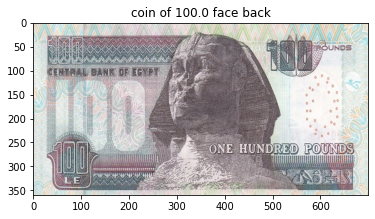

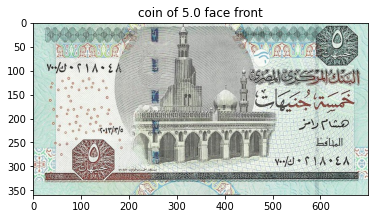

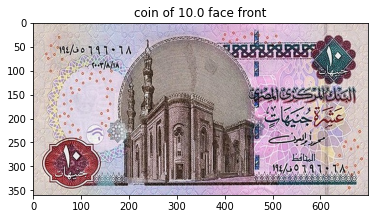

In [255]:
for i in range(len(Train_data.head())):
    plt.title(f"coin of {Train_data.iloc[i]['value']} face {Train_data.iloc[i]['face']}")
    plt.imshow(Train_data.iloc[i]['image'], cmap='gray')
    
    plt.show()

# prepare test

## segment image

In [256]:
def draw(im):
    plt.imshow(im, cmap='gray')
    plt.show()

In [257]:
def segment_neighbors(c_im, i, j, c):

    s = []
    s.append((i, j))

    while len(s):
        y, x = s[-1]
        if c_im[y, x - 1] ==  1:
            c_im[y, x - 1] = c
            s.append((y, x - 1))
            continue

        if c_im[y, x + 1] == 1:
            c_im[y, x + 1] = c
            s.append((y, x + 1))
            continue

        if c_im[y - 1, x] == 1:
            c_im[y - 1, x] = c
            s.append((y - 1, x))
            continue

        if c_im[y +  1, x] == 1:
            c_im[y + 1, x] = c
            s.append((y + 1, x))
            continue
        
        if c_im[y - 1, x - 1] == 1:
            c_im[y - 1, x - 1] = c
            s.append((y - 1, x - 1))
            continue

        if c_im[y + 1, x + 1] == 1:
            c_im[y + 1, x + 1] = c
            s.append((y + 1, x + 1))
            continue

        if c_im[y - 1, x + 1] == 1:
            c_im[y - 1, x + 1] = c
            s.append((y - 1, x + 1))
            continue

        if c_im[y + 1, x - 1] == 1:
            c_im[y + 1, x - 1] = c
            s.append((y + 1, x - 1))
            continue
        s.pop()

    return c_im

In [258]:
def segment_image(image_c):

    clu = 2
    fla = True

    for i in range(image_c.shape[0]):
        for j in range(image_c.shape[1]):

            if not fla and image_c[i, j] == 0:
                clu += 1
                fla = True

            while image_c[i, j] == 1:
                image_c[i, j] = clu
                image_c = segment_neighbors(image_c, i, j, clu)
                fla = False

    return image_c



## decrease noise

In [260]:
def decrease_noise(image, verbose=False):

    image_binary = np.int0(cv.cvtColor(image, cv.COLOR_RGB2GRAY) < 255)


    x = image_binary.shape[1]
    y = image_binary.shape[0]

    for i in range(y):
        for j in range(x):
            if image_binary[i, j] == 0 and ((j + 1 < x and image_binary[i, j + 1] == 1) or (j + 2 < x and image_binary[i, j + 2] == 1) or (j + 3 < x and image_binary[i, j + 3] == 1)):
                image_binary[i, j] = 1
    if verbose:
        draw(image_binary, cmap='gray')
        print("num of unique values:", np.unique(image_binary))

    image_binary = image_binary.astype(np.uint8)


    return image_binary

## split money

In [261]:
def filter_segmentation(image_c, verbose=False):
    unq_values = np.unique(image_c)
    l_v = []
    for i in unq_values:
        num_pixels = np.count_nonzero(image_c == i)
        if num_pixels > 60000 and i != 0:
            l_v.append((i,num_pixels))

    l_v = list(sorted(l_v, key=lambda x:x[1]))

    if verbose:
        print("values :", *l_v)

    return l_v

## get bounding boxes

In [262]:
def get_bound_box(binary_image):
    minx = float('inf')
    maxx = float('-inf')
    miny = float('inf')
    maxy = float('-inf')

    for i in range(binary_image.shape[0]):
        for j in range(binary_image.shape[1]):
            if binary_image[i,j] == 1:
                maxy = max(maxy, i)
                miny = min(miny, i)
                maxx = max(maxx, j)
                minx = min(minx, j)

    return (miny, maxy), (minx, maxx)

In [263]:
def get_images(segmentation_val, seg_image, org_image):

    list_image = []

    for val, num_pixels in segmentation_val:
        (y_min, y_max),(x_min, x_max) =  get_bound_box(np.int0(seg_image == val))
        list_image.append(((y_min, y_max),(x_min, x_max), org_image[y_min:y_max + 1, x_min:x_max + 1]))

    return list_image

## get oriantation

In [264]:

def get_oriantation(image, coordinates):

    (y_min, y_max), (x_min, x_max) = coordinates

    im_b = np.int0(cv.cvtColor(image, cv.COLOR_RGB2GRAY) < 255)
    im_b = im_b.astype('int8')

    is_orianted = False
    x1_flag = True
    x2_flag = True

    x1 = tuple()
    x2 = tuple()

    for i in range(im_b.shape[1]):

        if im_b[1, i] ==  1 and x1_flag: 
            x1 = (1, i)
            x1_flag = False
        if im_b[2, i] == 1 and x2_flag:
            x2 = (2, i)
            x2_flag = False

        if not (x1_flag or x2_flag):
            break

    if x2[1] - x1[1] != 0:

        is_orianted = True
        
        im_b = np.array(Image.fromarray(im_b).rotate(math.degrees(math.atan(1/(x2[1] - x1[1]))) - 15))
        image = np.array(Image.fromarray(image).rotate(math.degrees(math.atan(1/(x2[1] - x1[1]))) - 15))

        segmentation_val = filter_segmentation(np.int0(im_b > 0))

        (y_min, y_max), (x_min, x_max), image = get_images(segmentation_val, np.int0(im_b > 0), image)[0]

    return image, is_orianted



## Calc matching Similarity

In [421]:
def calc_matching(image_a, image_b):
    
    good_matches = []

    sift = cv.xfeatures2d.SIFT_create()

    _, descriptors1 = sift.detectAndCompute(image_a, None)
    _, descriptors2 = sift.detectAndCompute(image_b, None)

    bf = cv.BFMatcher()

    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    for d1, d2 in matches:
        if d1.distance < 0.25 * d2.distance:
            good_matches.append(d1)


    return len(good_matches)
    

# get values

test  1


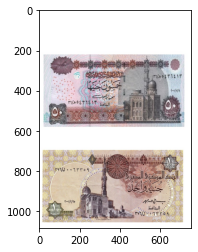

total money :  51.0
test  2


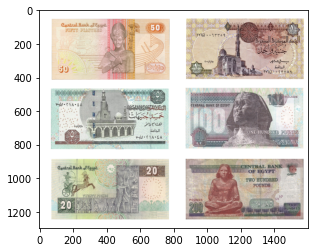

In [ ]:
for indx in range(len(test_data)):
    print("test ", indx + 1)

    image = test_data.iloc[indx]['image']
    
    draw(image)

    image_binary = decrease_noise(image)
    
    image_seg = segment_image(image_binary)

    segmented_val = filter_segmentation(image_seg)
    
    list_images = get_images(segmented_val, image_seg, image)
    total_money = 0

    for y_coor, x_coor, croped_image in list_images:

        flag_similart = []
        
        for i in range(len(Train_data)):

            similarity = calc_matching(croped_image, Train_data.iloc[i]['image'])

            flag_similart.append((similarity, Train_data.iloc[i]['value']))

        
        expected = max(flag_similart, key=lambda x:x[0])[1]
        total_money += expected
        
        
    print("total money : ", total_money)

    